## Discriminative vs	Generative	Models

In [1]:
#Python version
!python --version

Python 3.6.4 :: Anaconda, Inc.


In [2]:
from csv import reader #read csv
import random #gengerate random samples
from random import seed #set a seed
import pandas as pd #build a dataframe
import numpy as np #calculation
from scipy.stats import multivariate_normal #get probability from pdf
import matplotlib #plotting
import matplotlib.pyplot as plt 
matplotlib.style.use('ggplot')

### Step I:
I.	Load Task2D_train.csv and Task2D_test.csv as well as the Bayesian classifier (BC) and logistic regression (LR) codes from Activities 2 and 3 in Module 3.

In [3]:
# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    dataset.pop(0)
    return dataset

In [4]:
trainset=[[float(i) for i in a] for a in load_csv("Task2D_train.csv")]

In [5]:
testset=[[float(i) for i in a] for a in load_csv("Task2D_test.csv")]

#### Bayesian classifier

In [6]:
#calculate probability
def calculate_probability(data, c):
    count=0
    #in case there is no data
    if len(data)==0:
        return 0
    else:
        #for each row in data
        for each in data:
            #if label y euqals c
            if each[-1]==c:
                #count plus 1
                count+=1
        #calculate probability
        return count/len(data)

In [7]:
#calculate average
def mean(data):
    #in case there is no data
    if len(data)==0:
        return 0
    else: 
        #there are 2 coluns, and count their means
        col1mean=sum([i[0] for i in data])/len(data)
        col2mean=sum([i[1] for i in data])/len(data)
        return [col1mean, col2mean]

In [8]:
#calculate variance
def Variance(data):
    #if there is only one or does not have any data
    if (len(data))<=1:
        #variance should be 0
        return 0
    else:
        #else return variance matrix
        return np.cov([i[0] for i in data],[i[1] for i in data])

In [9]:
#BC method begins
def BC_prediction(train, test):
    #extract how many classes in label y
    classes_list=set()
    for each in testset:
        classes_list.add(each[-1])
    classes=list(classes_list)
    
    #calculate probability
    p0_hat=calculate_probability(train,classes[0])
    p1_hat=calculate_probability(train,classes[1])
    
    #extract each classes
    train_1=[]
    train_minus_1=[]
    for row in train:
        if row[-1]==1:
            train_1.append(row)
        else:
            train_minus_1.append(row)
    
    #calculate column mean
    mu0_hat=mean(train_1)
    mu1_hat=mean(train_minus_1)
    
    #calculate variance matrix
    sigma0_var=Variance(train_1)
    sigma1_var=Variance(train_minus_1)
    
    #calculate variance
    sigma_var=p0_hat*sigma0_var+p1_hat*sigma1_var 
    
    #extract data except for label
    test_x=[i[:-1] for i in test]
    
    #calculaye posterior probability for each classes
    posterior0 = p0_hat*multivariate_normal.pdf(test_x, mean=mu0_hat, cov=sigma_var)
    posterior0 = [float(words) for segments in posterior0 for words in str(segments).split()]

    posterior1 = p1_hat*multivariate_normal.pdf(test_x, mean=mu1_hat, cov=sigma_var)
    posterior1 = [float(words) for segments in posterior1 for words in str(segments).split()]
    
    #identify test label y should belong to which class
    predict=[]
    for i in range(len(posterior0)):
        if posterior0[i]>posterior1[i]:
            predict.append(classes[0]) 
        else:
            predict.append(classes[1])
    
    return predict

In [10]:
#calculate errors
def BC_error(train, test):
    #make a prediction of test
    predictions=BC_prediction(train, test)
    errors=0
    #extract real test labels
    test_y=[i[-1] for i in test]
    #count how many error that has been made
    for i in range(len(test)):
        if predictions[i] != test_y[i]:
            errors+=1
    return errors

#### Logistic regression

In [11]:
#sigmoid function 
def sigmoid(row, coefficients):
    #initial W0
    yhat = coefficients[0]
    #matrix multiplication
    for i in range(len(row)-1):
        yhat += coefficients[i + 1] * row[i]
    #return sigmoid
    return 1.0 / (1.0 + np.exp(-yhat))

In [22]:
# Estimate logistic regression coefficients using stochastic gradient descent
def coefficients_sgd(train, l_rate, n_epoch, epsilon):
    #generate random numbers for coefficient
    coef = [random.uniform(0,1) for n in range(len(train[0]))]
    #for each iteration
    for epoch in range(n_epoch):
        #initial errors
        sum_error = 0
        for row in train:
            #make a prediction
            yhat = sigmoid(row, coef)
            #difference between prediction and true label
            error = row[-1] - yhat
            #count errors
            sum_error += error**2
            ##calculate W0 by using SDG
            coef[0] = coef[0] + l_rate * error * yhat * (1.0 - yhat)
            for i in range(len(row)-1):
                #update the weights
                coef[i + 1] = coef[i + 1] + l_rate * error * yhat * (1.0 - yhat) * row[i]
        #if error less than threshold, then break the for loop
        if sum_error<=epsilon:
            break
    return coef

In [13]:
# Linear Regression Algorithm With Stochastic Gradient Descent
def logistic_regression(train, test, l_rate, n_epoch, epsilon):
    #show all of features in train label
    classes_list=set()
    for each in train:
        classes_list.add(each[-1])
    classes=list(classes_list)

    #change feature of train set
    for element in train:
        for n, i in enumerate(element):
            #if prediction is 1, then change to 0
            if i == classes[0]:
                element[n] = 0
            #if prediction is -1, then change to 1
            elif i==classes[1]:
                element[n]= 1
                    
    predictions=[]
    #calculate the coefficient of logistic regression
    coef=coefficients_sgd(train, l_rate, n_epoch, epsilon)
    for row in test:
        yhat = sigmoid(row, coef)
        #round the number and see which class it is
        yhat = round(yhat)
        predictions.append(yhat)
    
    #for each element in traing set
    for element in train:
        for n, i in enumerate(element):
            #if prediction is 0, then change back to 1
            if i ==0:
                element[n] = classes[0]
            #if prediction is 1, then change back to -1
            elif i==1:
                element[n]= classes[1]
                
    #change prediction back
    for idx, pred in enumerate(predictions):
        #if prediction is 0, then change back to 1
        if pred==0:
            predictions[idx]=classes[0]
        #if prediction is 1, then change back to -1
        else:
            predictions[idx]=classes[1]
        
    return(predictions)

In [14]:
#calculate errors using LR method
def LR_errors(train, test, l_rate, n_epoch, epsilon):
    #make a prediction
    predictions=logistic_regression(train, test, l_rate, n_epoch, epsilon)
    errors=0
    #ture test label
    test_y=[i[-1] for i in test]
    #for every row in test set
    for i in range(len(test)):
        #if prediction is not equal to ture y, error set counts by 1
        if predictions[i] != test_y[i]:
            errors+=1
    return errors

### Step II.	
Using the first 5 data points from the training set, train a BC and a LR model, and compute their test errors. In a “for loop”, increase the size of training set (5 data points at a time), retrain the models and calculate their test errors until all training data points are used. In one figure, plot the test errors for each model (with different colors) versus the size of the training set; include the plot in your Jupyter Notebook file for Question 9.

In [23]:
l_rate=0.01  #learning rate
n_epoch=1000 #max iteration
epsilon=0.01 #threshold for errors

BC_ERRORS=[]
LR_ERRORS=[]

#set a seed to fix output
seed(7)
#increase the size of training set
for idx in range(5, len(trainset), 5):
    #shuffle samples
    training = random.sample(trainset, len(trainset))
    #calculate errors for each method
    bc=BC_error(training[:idx], testset)
    lr=LR_errors(training[:idx], testset, l_rate, n_epoch, epsilon)
    BC_ERRORS.append(bc)
    LR_ERRORS.append(lr)

In [24]:
#building a dataframe contains training set, BC errors and LR errors
df_error=pd.DataFrame({"training set": [i for i in range(5, len(trainset), 5)],
                       "BC errors": BC_ERRORS,
                       "LR errors": LR_ERRORS})
#set dataframe index with training set
df_error= df_error.set_index('training set')
df_error

,BC errors,LR errors
training set,,
5,93,10
10,7,7
15,6,10
20,18,16
25,14,10
30,12,13
35,13,10
40,12,8
45,7,6


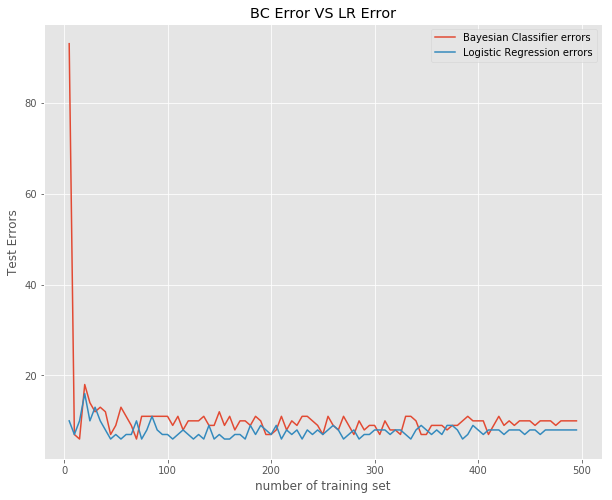

In [25]:
#plot a graph
plt.figure(figsize=(10,8))
plt.plot(df_error)

#set x-axis  label
plt.xlabel("number of training set")
#set y-axis label
plt.ylabel("Test Errors")
#set title
plt.title('BC Error VS LR Error')
plt.legend(labels=['Bayesian Classifier errors','Logistic Regression errors'])
plt.show()

### Summary：

* (a). When the number of training data points increase, the test error for both classifiers would decrease. But for Bayesian classfier, it has a large decrease jump at very begining.

* (b). I would take Bayesian Classfier when dataset is small and Logistic regression when dataset is large. 
* (c). Speculation and Reasons:
    *  We can see from plot that LG always has lower errors than BC as the number of training set increasing. However, when there are very few training instances, which might indicate the model must have high bias. Logistic regression might "overfit", because there isn't enough data to estimate p(y|x) reliably. Bayesian might do better because it models the entire joint distribution. So, when we have a small data set, we need models that have few parameters (low complexity) and/or a strong prior. So in this case, high bias/low variance classifiers (Bayesian Classfier) have an advantage over low bias/high variance classifiers (Logistic Regression)
    
    * When the feature set is large, bayesian might "double count" features that are correlated with each other, because it assumes that each p(x|y) event is independent, when they are not. In classification, Bayesian converges quicker but has typically a higher error than logistic regression. And it assumes that the features are conditionally independent. Real data sets are never perfectly independent but they can be close. However, Logistic regression can do a better job by naturally "splitting the difference" among these correlated features. In short, Naive Bayes has a higher bias but lower variance compared to logistic regression so that when dataset is large, we would take Logistic regression.
